In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal

In [2]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)
        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layerout = nn.Linear(self.hidden_dim, x_dim, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=2)
        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 
        z_out = self.layerout(h) 
        return z_out

In [3]:
N = 2000 # number of samples
T = 100  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 1.0 # time horizon
dt = tf/T # time step

n_sigma = 1 # noise level

A = torch.tensor([[0.0, 1.0],[0.0, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [4]:
x_0 = MultivariateNormal(torch.zeros(n), torch.eye(n)).sample((N,))
y = MultivariateNormal(torch.tensor([3.0,3.0]), torch.eye(n)).sample((N,))

In [5]:
X_f = torch.zeros((T, N, n))
W_f = torch.zeros((T, N, m))


X_f[0] = x_0

t = torch.linspace(0.0, tf, T).reshape(-1,1) # shape (T,1)

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)

In [6]:
for i in range(T):
    W_f[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))

In [7]:
# W_f[:,:,0] = 0.0
W_f = torch.cat((torch.zeros((T,N,1)), W_f), dim=2)


In [8]:
A_t = torch.zeros((T, N, n, n))
B_t = torch.zeros((T, N, n, n))

A_t[:,:,0,0] = 2*t_N[:,:,0]**3 - 3*t_N[:,:,0]**2 + 1
A_t[:,:,0,1] = t_N[:,:,0]**3 - 2*t_N[:,:,0]**2 + t_N[:,:,0]
A_t[:,:,1,0] = 6*t_N[:,:,0]**2 - 6*t_N[:,:,0]
A_t[:,:,1,1] = 1 + 2*t_N[:,:,0] - 3*t_N[:,:,0]**2

B_t[:,:,0,0] = 3*t_N[:,:,0]**2 - 2*t_N[:,:,0]**3
B_t[:,:,0,1] = t_N[:,:,0]**3 - t_N[:,:,0]**2
B_t[:,:,1,0] = 6*t_N[:,:,0] - 6*t_N[:,:,0]**2
B_t[:,:,1,1] = -2*t_N[:,:,0] + 3*t_N[:,:,0]**2

Sigma_t = torch.zeros((T, N, n, n))
Sigma_t[:,:,0,0] = t_N[:,:,0]**3/3
Sigma_t[:,:,0,1] = -t_N[:,:,0]**2/2
Sigma_t[:,:,1,0] = -t_N[:,:,0]**2/2
Sigma_t[:,:,1,1] = t_N[:,:,0]

Sigma_reshaped = Sigma_t.reshape(-1, n, n)  # Shape (T*N, 2, 2)

## check these lines
# Vectorize the sqrtm function to apply it across all (2, 2) matrices
sqrtm_vectorized = np.vectorize(sp.linalg.sqrtm, signature='(m,n)->(m,n)')
sqrt_Sigma_reshaped = sqrtm_vectorized(Sigma_reshaped)

# Reshape back to the original shape (T, N, 2, 2)
sqrt_Sigma= sqrt_Sigma_reshaped.reshape(T, N, n, n)

In [9]:
X_f = torch.einsum('tnij,tnj->tni', A_t, x_0.unsqueeze(0).repeat(T,1,1)) + torch.einsum('tnij,tnj->tni', B_t, y.unsqueeze(0).repeat(T,1,1)) + n_sigma * torch.einsum('tnij,tnj->tni', torch.Tensor(sqrt_Sigma), W_f)

In [10]:
print(X_f[-1,:,:].mean(dim = 0))
print(X_f[-1,:,:].std(dim = 0))

tensor([3.0024, 2.9734])
tensor([0.9892, 0.9981])


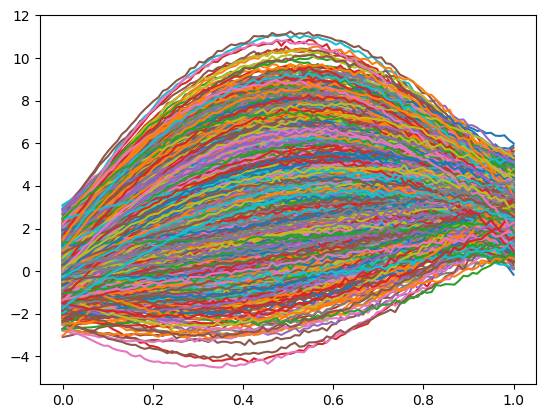

In [11]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,1])

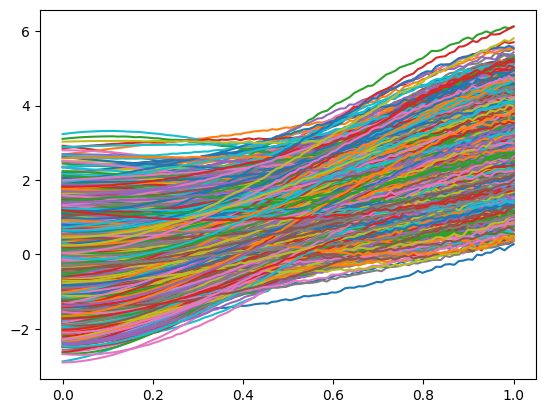

In [12]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,0])

In [13]:
ITERS = 10000
BATCH_SIZE = 32
LR = 1e-3

f = score_nn(n,16)
# init_weights(f)
f.train()
optimizer_f = torch.optim.Adam(f.parameters(), lr=LR)

for i in range(ITERS):
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_f[:,idx,:]
    t_train = t_N[:,idx,:]  
    Y_train = y[idx,:]
    f_value = f.forward(X_train,t_train) 
    loss = ((f_value-Y_train)*(f_value-Y_train)).mean()
    
    optimizer_f.zero_grad()
    loss.backward()
    optimizer_f.step()
    
    if  (i+1)==ITERS or (i+1)%100==0:
        f_value = f.forward(X_f,t_N)
        loss = ((f_value-y)*(f_value-y)).mean()
        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 100/10000, loss = 1.621223092079
Iteration: 200/10000, loss = 0.987996220589
Iteration: 300/10000, loss = 0.902097642422
Iteration: 400/10000, loss = 0.860391855240
Iteration: 500/10000, loss = 0.824891328812
Iteration: 600/10000, loss = 0.784646868706
Iteration: 700/10000, loss = 0.732649683952
Iteration: 800/10000, loss = 0.701713740826
Iteration: 900/10000, loss = 0.695289075375
Iteration: 1000/10000, loss = 0.682829201221
Iteration: 1100/10000, loss = 0.676915287971
Iteration: 1200/10000, loss = 0.676294267178
Iteration: 1300/10000, loss = 0.672180771828
Iteration: 1400/10000, loss = 0.676787197590
Iteration: 1500/10000, loss = 0.669918596745
Iteration: 1600/10000, loss = 0.669696569443
Iteration: 1700/10000, loss = 0.668747961521
Iteration: 1800/10000, loss = 0.665313065052
Iteration: 1900/10000, loss = 0.673247575760
Iteration: 2000/10000, loss = 0.667888104916
Iteration: 2100/10000, loss = 0.663586378098
Iteration: 2200/10000, loss = 0.685604691505
Iteration: 2300/100

In [26]:
N = 2000
T = 1000

t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T

W_b = torch.zeros((T, N, m))
for i in range(T):
    W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
# W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

X_b = torch.zeros(T,N,n)
X_b[0] = torch.randn(N,n)
#X_b[0] = X[0].clone()
for i in range(0,T-1):
    y_pred = f.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
    print(torch.inverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])))
    u = (torch.tensor([[1 - t[i,0,0],1]]) @ torch.inverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])) @ (y_pred - (torch.tensor([[1, 1-t[i,0,0]],[0, 1]]) @ X_b[i].T).T).T).T
    X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u.T).T * dt + n_sigma * W_b[i]

tensor([[12.0000, -6.0000],
        [-6.0000,  4.0000]])
tensor([[12.0361, -6.0120],
        [-6.0120,  4.0040]])
tensor([[12.0724, -6.0241],
        [-6.0241,  4.0080]])
tensor([[12.1088, -6.0362],
        [-6.0362,  4.0120]])
tensor([[12.1453, -6.0483],
        [-6.0483,  4.0161]])
tensor([[12.1820, -6.0605],
        [-6.0605,  4.0201]])
tensor([[12.2188, -6.0727],
        [-6.0727,  4.0242]])
tensor([[12.2558, -6.0850],
        [-6.0850,  4.0282]])
tensor([[12.2930, -6.0973],
        [-6.0973,  4.0323]])
tensor([[12.3303, -6.1096],
        [-6.1096,  4.0364]])
tensor([[12.3677, -6.1219],
        [-6.1219,  4.0404]])
tensor([[12.4053, -6.1343],
        [-6.1343,  4.0445]])
tensor([[12.4430, -6.1468],
        [-6.1468,  4.0486]])
tensor([[12.4809, -6.1593],
        [-6.1593,  4.0527]])
tensor([[12.5190, -6.1718],
        [-6.1718,  4.0569]])
tensor([[12.5572, -6.1843],
        [-6.1843,  4.0610]])
tensor([[12.5956, -6.1969],
        [-6.1969,  4.0651]])
tensor([[12.6341, -6.2095],
   

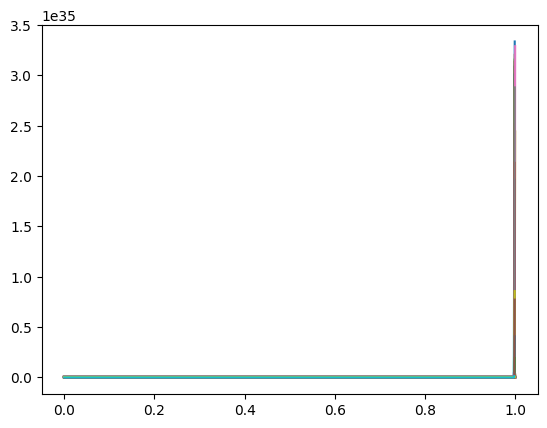

In [25]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,1].detach().numpy())

(array([1.24275199e-29, 4.97100794e-29, 2.48550397e-29, 9.94202157e-29,
        7.45651191e-29, 4.97100794e-29, 4.97100794e-29, 3.72825596e-29,
        2.48550468e-29, 6.21375993e-29]),
 array([-2.16429102e+28, -1.95796646e+28, -1.75164190e+28, -1.54531734e+28,
        -1.33899290e+28, -1.13266834e+28, -9.26343777e+27, -7.20019218e+27,
        -5.13694658e+27, -3.07370157e+27, -1.01045605e+27]),
 <BarContainer object of 10 artists>)

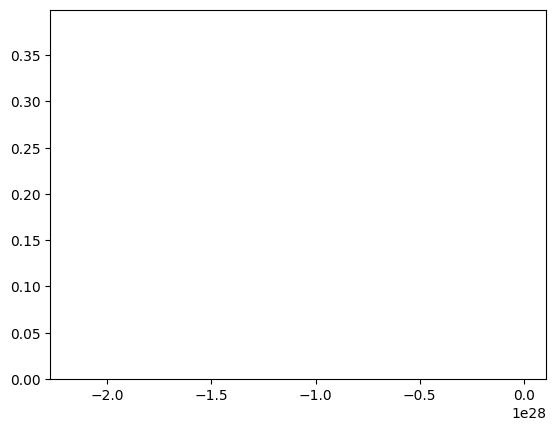

In [16]:
plt.hist(y.numpy()[:,1],alpha=0.2, color='r',density=True)
plt.hist(X_b.detach().numpy()[-1,:,1],alpha=0.2, density=True)